# Predicting Failure in Industrial Machines
## Introduction and Motivation
One application of data science that I find really interesting is using the signal off industrial machine sensors to predict future failure. Not only does this save the company money, but also energy if they can avoid machinery downtime.  In this example, data was generated by simulating a turbo fan in this [paper](https://ieeexplore.ieee.org/document/4711414).  The object is to predict how many cycles the fan has left at each measurement before failure and thus is a regression problem.

## Loading Data and Libraries 
Let's first start by importing all the packages we need.  This list comes from going through the problem and importing as needed.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import seaborn as sns; sns.set()
import time
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
import warnings

Now let's import the data.  The data folder has a bunch of different training and test sets.  The eventual object is for the program to train on each set and improve its accuracy as it goes.  Since this is one of my first forays into a dataset beyond kaggle, I kept it simple and only looked at one data set.  Future work would include scaling this to look at all the other data sets, so we should keep that in mind as we do our analysis.  Note, doing a bit of reading from where the data comes from lets us see what the column names are ahead of time and lets us add them in as we import the data.

In [2]:
feat_names = ['Unit', 'CycleNo', 'opset1', 'opset2', 'opset3', 'sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5',
              'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14',
              'sensor15', 'sensor16', 'sensor17','sensor18', 'sensor19','sensor20', 'sensor21','sensor22', 'sensor23',
              'sensor24', 'sensor25', 'sensor26']  

data_train1 = pd.read_csv('./CMAPSSData/train_FD001.txt', sep = ' ', header = None, names=feat_names)

## Exploratory Data Analysis
As with all data, we should do some basic exploratory data analysis to see what we are dealing with.

In [3]:
data_train1.info()
data_train1.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 31 columns):
Unit        20631 non-null int64
CycleNo     20631 non-null int64
opset1      20631 non-null float64
opset2      20631 non-null float64
opset3      20631 non-null float64
sensor1     20631 non-null float64
sensor2     20631 non-null float64
sensor3     20631 non-null float64
sensor4     20631 non-null float64
sensor5     20631 non-null float64
sensor6     20631 non-null float64
sensor7     20631 non-null float64
sensor8     20631 non-null float64
sensor9     20631 non-null float64
sensor10    20631 non-null float64
sensor11    20631 non-null float64
sensor12    20631 non-null float64
sensor13    20631 non-null float64
sensor14    20631 non-null float64
sensor15    20631 non-null float64
sensor16    20631 non-null float64
sensor17    20631 non-null int64
sensor18    20631 non-null int64
sensor19    20631 non-null float64
sensor20    20631 non-null float64
sensor21    20631 non-nu

,Unit,CycleNo,opset1,opset2,opset3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23,sensor24,sensor25,sensor26
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.0,20631.0,20631.000000,20631.000000,0.0,0.0,0.0,0.0,0.0
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,393.210654,2388.0,100.0,38.816271,23.289705,NaN,NaN,NaN,NaN,NaN
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,1.548763,0.0,0.0,0.180746,0.108251,NaN,NaN,NaN,NaN,NaN
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,388.000000,2388.0,100.0,38.140000,22.894200,NaN,NaN,NaN,NaN,NaN
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,392.000000,2388.0,100.0,38.700000,23.221800,NaN,NaN,NaN,NaN,NaN
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,393.000000,2388.0,100.0,38.830000,23.297900,NaN,NaN,NaN,NaN,NaN
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,394.000000,2388.0,100.0,38.950000,23.366800,NaN,NaN,NaN,NaN,NaN
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,400.000000,2388.0,100.0,39.430000,23.618400,NaN,NaN,NaN,NaN,NaN


It looks like we don't have any mixed data types since all the columns are either 'float64' or 'int64.'  Additionally, it doesn't look like we have any missing data except in 'sensor22'- 'sensor26' columns.  This does not mean we don’t have corrupt values which could be listed as some number like '9999'.  So we should be aware of that in the future.

I also like to see if I can broadly catch any 'NaN's in the dataframe.

In [9]:
data_train1.isna().sum()

Unit            0
CycleNo         0
opset1          0
opset2          0
opset3          0
sensor1         0
sensor2         0
sensor3         0
sensor4         0
sensor5         0
sensor6         0
sensor7         0
sensor8         0
sensor9         0
sensor10        0
sensor11        0
sensor12        0
sensor13        0
sensor14        0
sensor15        0
sensor16        0
sensor17        0
sensor18        0
sensor19        0
sensor20        0
sensor21        0
sensor22    20631
sensor23    20631
sensor24    20631
sensor25    20631
sensor26    20631
dtype: int64

It looks like sensor 22 through 26 is full of NaNs so in this case we can drop those columns. At the next iteration of this project, we will have figure out a way to catch which columns have NaNs since in different data sets different sensors might be switched off or not recording.

In [4]:
data_train1 = data_train1.drop(['sensor22','sensor23','sensor25','sensor26','sensor24'], axis=1)

Looking at the 'opset' columns it looks like there's a pretty tight distribution of values.  Let's visualize this to get a better sense of that data.

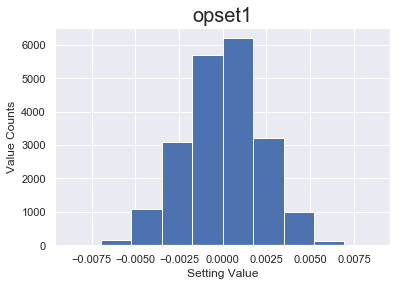

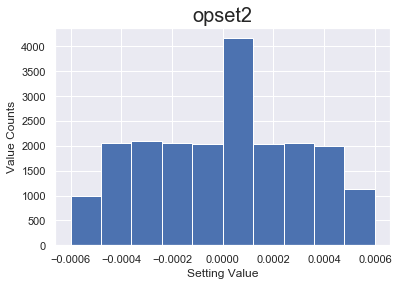

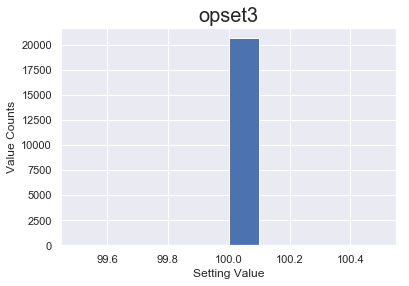

In [5]:
for setting in ['opset1', 'opset2', 'opset3']:
    plt.figure()
    plt.title(setting, fontsize = 20)
    plt.hist( data_train1[setting])
    plt.xlabel('Setting Value')
    plt.ylabel('Value Counts')
    plt.show()

As expected there's a tight distribution which means either the settings are constant or don't change much within the dataset from unit to unit. 

Let’s do some exploratory data analysis on just one unit to get a sense for what a sample of data would look like.

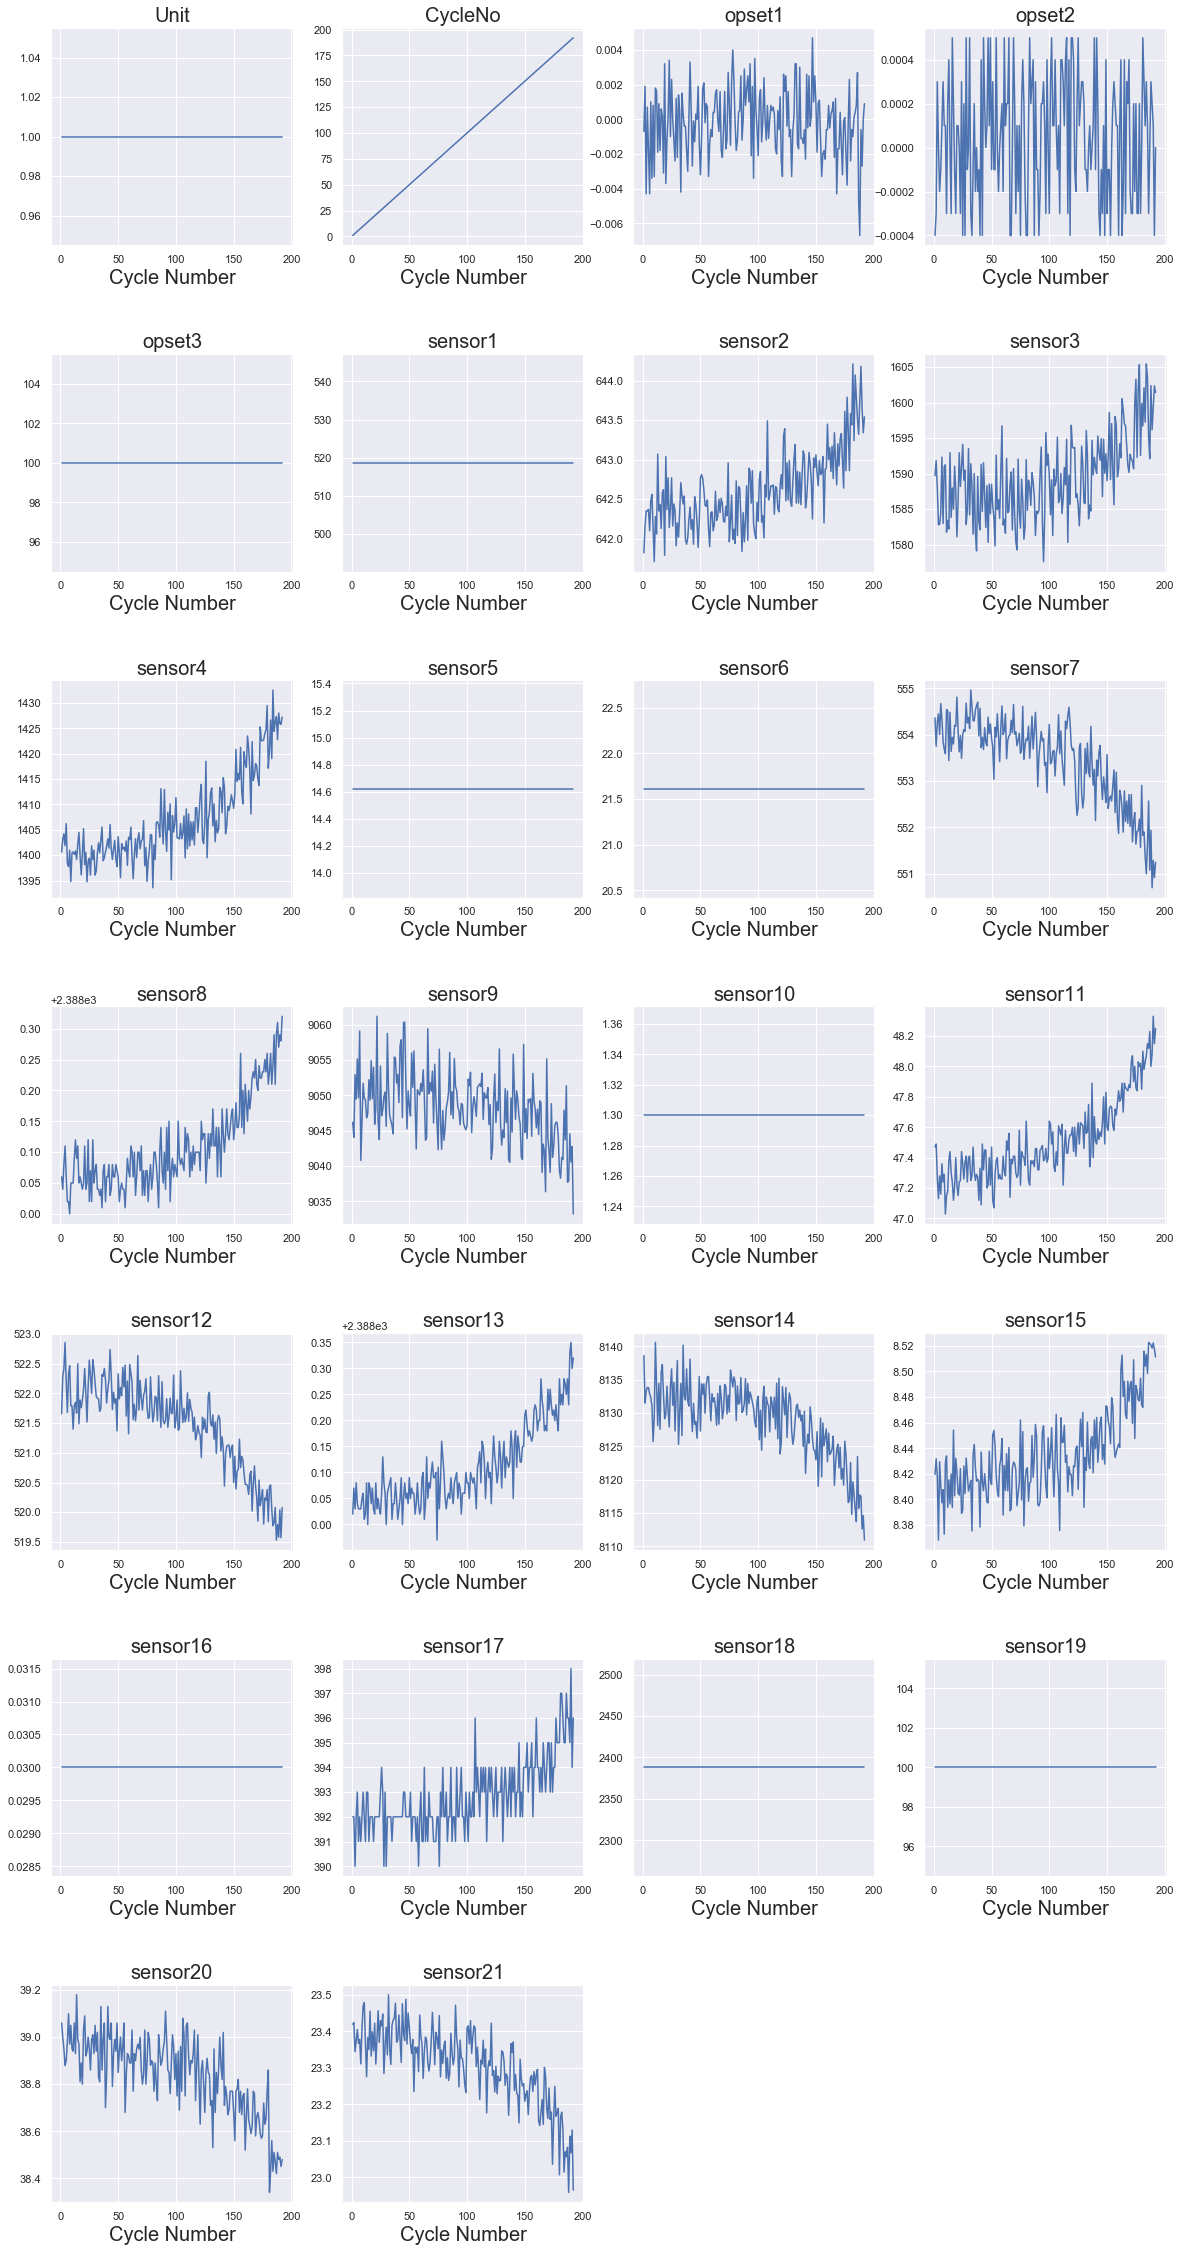

In [6]:
unit_1_data = data_train1[data_train1['Unit'] == 1]

plt.figure(figsize=(20,40), facecolor='white')
plot_number = 1
for column in unit_1_data.columns:
    plt.subplot(7, 4, plot_number)
    plt.subplots_adjust(hspace = 0.5)
    plt.plot(unit_1_data['CycleNo'], unit_1_data[column])
    plt.title(column, fontsize = 20 )
    plt.xlabel('Cycle Number', fontsize = 20)
    plot_number += 1
plt.show()


Cool, we get a nice overview of what some of the sensor data looks like.  Some stay flat (maybe it's broken?), while others shift with time.  One thing to point out is that these subplots are on different scales so we will need to keep that in mind when we start training our models and potentially use standardization or normalization.

### Adding Target variable to Dataframe

Now that we have a feel for the data, we need to figure out a target variable.  In this case, it would be the number of cycles left until the fan breaks.  Thus, for each unit we need to calculate the max number of entries and call that max number the point of failure.  Then each entry before that would be a countdown until failure.  This section is written into a function because one can imagine when we look at a test set or another dataset beyond this first one, we would need to create the target variable each time. 

Note: The best I could come up with is a for loop with O(n) time complexity.  If someone has a better way to do it, feel free to let me know as I am always looking to improve.


In [7]:
def create_cycles_left(data):
    '''
    Intakes: Data set from turbo fan data
    Outputs: Data with calculated countdown until the last cycle which is deemed the failure point. 
    '''
    max_cycle = data.groupby('Unit')['CycleNo'].max().reset_index()
    for x in max_cycle.iloc[:, 0]:
        count_cycle = max_cycle.iloc[x-1, 1]
        data.loc[data['Unit'] == x, 'RUL'] = count_cycle - data['CycleNo']
    return data

In [8]:
data_train1 = create_cycles_left(data_train1)
data_train1.columns

Index(['Unit', 'CycleNo', 'opset1', 'opset2', 'opset3', 'sensor1', 'sensor2',
       'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8',
       'sensor9', 'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14',
       'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20',
       'sensor21', 'RUL'],
      dtype='object')

Cool, now we've added the target 'RUL' column.  Let's plot some of the data to get a sense for what the distribution of max cycles is.


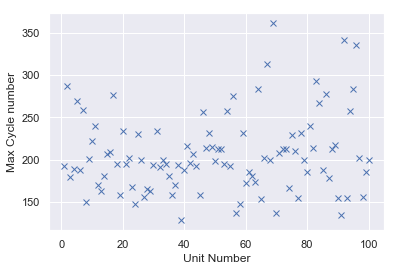

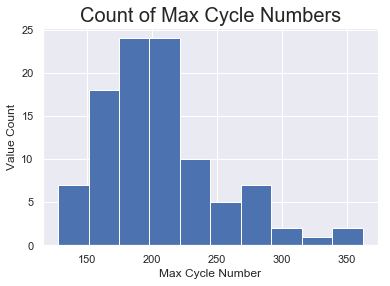

In [9]:
max_cycle = data_train1.groupby('Unit')['CycleNo'].max().reset_index()
plt.figure()
plt.plot(max_cycle.iloc[:,0],max_cycle.iloc[:,1], 'x')
plt.xlabel('Unit Number')
plt.ylabel('Max Cycle number')
plt.show()
plt.figure()
plt.hist(max_cycle.iloc[:,1], bins = 10)
plt.title('Count of Max Cycle Numbers', fontsize = 20)
plt.xlabel('Max Cycle Number')
plt.ylabel('Value Count')
plt.show()


So, it looks like we have a decent distribution of cycles with the average around 200.  This information will be useful when we start doing accuracy metrics as it'll give us a sense of how good the root mean square error value is for example.

## Preparing Data for Algorithms
Going back to our EDA, we want to normalize or standardize our data since each sensor has different scales.  Here we pick normalization as it will remove the effect of outliers.  Additionally, standardization assumes the data is distributed normally which we can't guarantee.


In [10]:
df = data_train1.drop(['RUL','Unit','CycleNo'], axis=1)

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df)
df_normalized = pd.DataFrame(np_scaled)
df_normalized.columns = df.columns

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


As in good data science practice, we should hold out some of our data so it's never trained  on and thus will give us an objective way to test the accuracy of our models. 

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_normalized, data_train1["RUL"], test_size=0.3, random_state=5)

Since this is a first foray into machine learning, I wanted to look at a variety of techniques and compare.  This will help us get a feel for different techniques and in the future hopefully not need to do this comparison.

Below is a function that will compare any number of different algorithms using cross fold validation.  It will return a dataframe with a summary of the results as well as the MSE for each fold of each technique. 

In [17]:
def compare_algorithms(algorithms, X_data, y_data, scoring = 'neg_mean_squared_error', num_folds = 3, seed = 5):
    '''
    Intake: list of (names: algorithms) to compare scoring metric and run time using cross fold validation. 
    Returns: Data frame with a summary of the data and the MSE for each fold of each technique.
    '''
    #This line for ignoring the warnings talking about how certain features will be depreciated in the future.
    warnings.filterwarnings("ignore")
    results = []
    names = []
    times = []
    results_mean =[]
    results_std = []
    for name, model in algorithms:
        kfold = KFold(n_splits=num_folds, random_state=seed)
        start = time.time()
        cv_results = cross_val_score(model, X_data, y_data, cv=kfold, scoring='neg_mean_squared_error')
        RMSE_CV_results = (abs(cv_results))**0.5
        results.append(RMSE_CV_results)
        results_mean.append(RMSE_CV_results.mean())
        results_std.append(RMSE_CV_results.std())
        run_time = time.time()-start
        names.append(name)
        times.append(run_time)
        
    algorithms_df = pd.DataFrame(
        {'Names': names,
         'Mean MSE': results_mean,
         'Std': results_std,
         'Time (s)': times,
        })
    return algorithms_df, results

Lets try some common regression models as well as one ensemble method in `RandomForestRegressor()` to see if we should maybe look at other ensemble methods.

In [18]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
models.append(('Bagging', RandomForestRegressor()))

single_model_compare, results = compare_algorithms(models, X_train, y_train, num_folds = 7)

In [14]:
print(results)

[array([-2054.54843255, -1913.07698084, -2003.04540282, -1832.99597885,
       -2013.4691652 , -2082.4966378 , -2027.52639135]), array([-2192.05792354, -2059.81090145, -2139.26144214, -1979.85433182,
       -2174.97962418, -2206.8203533 , -2149.58298272]), array([-3748.13236073, -3601.71583152, -3565.75874565, -3487.87202713,
       -3657.78393931, -3647.16406688, -3590.61400193]), array([-2306.45291323, -2045.37929229, -2198.26634998, -2053.92635967,
       -2211.52769753, -2244.11470674, -2164.54823073]), array([-3717.25836161, -3321.32573921, -3692.35773146, -3418.95346583,
       -3535.86427533, -3382.7464857 , -3545.59379544]), array([-2431.30424641, -2240.15480849, -2308.5138632 , -2128.12371562,
       -2342.62796883, -2368.23181709, -2307.16345418]), array([-2029.55125061, -1833.39310228, -1987.98546777, -1748.92480853,
       -1958.69276781, -1915.2903684 , -1929.64166747])]


Let's plot some of these results to see how they compare to each other.

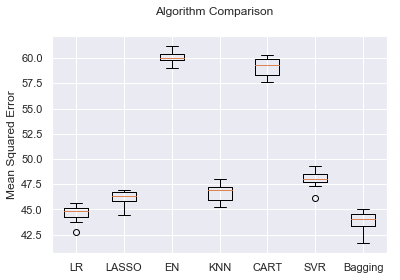

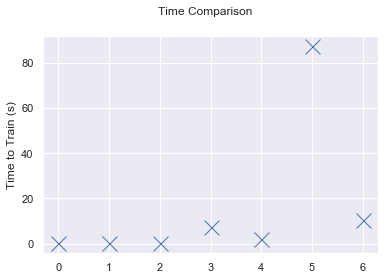

     Names   Mean MSE       Std   Time (s)
0       LR  44.595557  0.911284   0.143616
1    LASSO  46.132763  0.823300   0.166553
2       EN  60.114511  0.627932   0.090761
3      KNN  46.625861  0.957607   7.484994
4     CART  59.096482  0.996679   2.002677
5      SVR  47.987892  0.945318  87.700580
6  Bagging  43.804462  1.107259  10.538832


In [19]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(single_model_compare['Names'])
ax.set_ylabel('Mean Squared Error')
plt.show()    

fig1 = plt.figure()
fig1.suptitle('Time Comparison')
ax1 = fig1.add_subplot(111)
plt.plot(single_model_compare['Time (s)'], 'x', ms = 15)
ax1.set_ylabel('Time to Train (s)')

plt.show()

print(single_model_compare)

It looks like the ensemble method of random forest might be the best option.  There is an argument to be made that linear regression was almost as good but way faster.  We can check on that in the future.  For now, we will use the same iterative method to get a quick idea of how other ensemble methods would fair.  Let's leave the random forest regressor in there so we can easily plot it to see how it matches up.

In [20]:
ensemble_methods = []
ensemble_methods.append(('AdaBoost', AdaBoostRegressor()))
ensemble_methods.append(('GradientBoosting', GradientBoostingRegressor()))
ensemble_methods.append(('ExtraTree', ExtraTreesRegressor()))
ensemble_methods.append(('Random Forest', RandomForestRegressor()))

ensemble_methods_df, results = compare_algorithms(ensemble_methods, X_train, y_train, num_folds = 7)

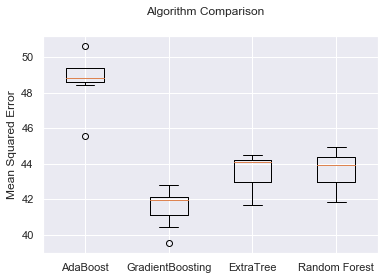

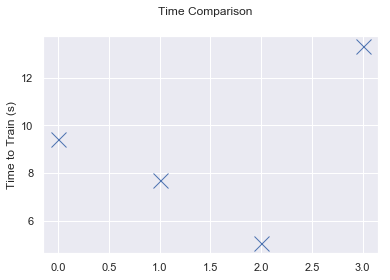

              Names   Mean MSE       Std   Time (s)
0          AdaBoost  48.699941  1.449179   9.442804
1  GradientBoosting  41.533987  1.057981   7.718371
2         ExtraTree  43.514306  1.000265   5.063560
3     Random Forest  43.623726  1.033559  13.337354


In [21]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(ensemble_methods_df['Names'])
ax.set_ylabel('Mean Squared Error')
plt.show()    

fig1 = plt.figure()
fig1.suptitle('Time Comparison')
ax1 = fig1.add_subplot(111)
plt.plot(ensemble_methods_df['Time (s)'], 'x', ms = 15)
ax1.set_ylabel('Time to Train (s)')
plt.show()

print(ensemble_methods_df)

It looks like gradient boosting is the best method and is rather quick.  One side note it is that 'both Random Forest' and 'Extra Tree's' distributions seem to lay within Gradient boosting's standard deviations.  We'll come back and look to see what happens if we optimize one or both of those methods.  One thing to note is that the gradient boosting method is sensitive to outliers and should be kept in mind going forward. 

## Hyperparameter Tuning
### Gradient Boosting Regressor
Now that we have a broad sense of where to look, let's tune the hyperparameters of the gradient boosting method.  We'll begin by using `RandomizedSearchCV()` to get a sense of quickly where to look and then use those results to do a more focused `GridSearchCV`.

In [ ]:
GBM = GradientBoostingRegressor(random_state = 42)


n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 3, stop = 50, num = 10)]
#post says this should be ~1% total samples but default is 2 so trying a range
min_samples_split = [2, 10, 100] 
#Want to pick small values to prevent over fitting 
min_samples_leaf = [1, 20, 40, 60, 80]

learning_rate = [0.002, 0.02, 0.2]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate}

GBM_random = RandomizedSearchCV(estimator =GBM, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
GBM_random.fit(X_train, y_train)
print(GBM_random.best_params_)

This can take awhile.  So if the reader wants to skip ahead in running the kernal below is the best params found.

In [21]:
estimators_random = {'n_estimators': 60, 'min_samples_split': 100, 'min_samples_leaf': 60, 'max_features': 'sqrt', 'max_depth': 3, 'learning_rate': 0.2}

Great, now let's see how much this hyperparameter tuning helped our accuracy by testing it vs the base model.  We can write a function to do this comparison.

In [24]:
def evaluate_model(model, test_features, test_labels, model_name = 'general'):
    predictions = model.predict(test_features)
    RMSE = (mean_squared_error(test_labels, predictions))**0.5
    print('Model Performance of '+ model_name)
    print('Root Mean Squared Error: {:0.4f} cycles.'.format(np.mean(RMSE)))

Now the comparison:

In [23]:
base_model = GradientBoostingRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate_model(base_model, X_test, y_test, 'Base model Gradient Boosting')

best_random = GradientBoostingRegressor(**estimators_random)
best_random.fit(X_train, y_train)
random_accuracy = evaluate_model(best_random, X_test, y_test, 'RandomCV Gradient Boosting')

Model Performance of Base model Gradient Boosting
Root Mean Squared Error: 48.5009 cycles.
Model Performance of RandomCV Gradient Boosting
Root Mean Squared Error: 41.6555 cycles.


Cool we've been able to get down to about 7 cycles less than then the baseline model just doing a random hyperparameter tuning.  Now we can use a grid search to see if we can get this score better.

In [ ]:
param_grid = {'n_estimators': [ 55,60,65,70],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [2,3,4,5],
               'min_samples_split': [95,100,105, 110],
               'min_samples_leaf': [55,60,65],
               'learning_rate': [0.15,0.2,0.25]}
# Create a based model
GBM = GradientBoostingRegressor()
# Instantiate the grid search model
GBM_grid_search = GridSearchCV(estimator = GBM, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
GBM_grid_search.fit(X_train, y_train)
print(GBM_grid_search.best_params_)

This also takes a bit of time to finish so like previously, we have included the best parameters found below:

In [25]:
estimators_grid = {'learning_rate': 0.15, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'min_samples_split': 110, 'n_estimators': 60}

Compare with the baseline and random. 

In [26]:
base_model = GradientBoostingRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate_model(base_model, X_test, y_test, 'Baseline Gradient Boosting')

best_random = GradientBoostingRegressor(**estimators_random)
best_random.fit(X_train, y_train)
random_accuracy = evaluate_model(best_random, X_test, y_test, 'RandomCV Gradient Boosting')

best_grid = GradientBoostingRegressor(**estimators_grid)
best_grid.fit(X_train, y_train)
grid_accuracy = evaluate_model(best_grid, X_test, y_test, 'GridCV Gradient Boosting')


Model Performance of Baseline Gradient Boosting
Root Mean Squared Error: 48.5009 cycles.
Model Performance of RandomCV Gradient Boosting
Root Mean Squared Error: 41.7681 cycles.
Model Performance of GridCV Gradient Boosting
Root Mean Squared Error: 41.6317 cycles.


It doesn't look like we are getting much better with only a ~0.1 improvement.  This is where some more domain knowledge would be useful from the company.  How much is a ~0.1 improvement worth?  Does having this improvement across 1000's of fans worth the additional tuning?

### Random Forest Regressor
As noted, another model to be used is the random forest which at the upper part of its broad RMSE range is in the range of the Gradient booster.  Thus, let's see if we can optimize it in the same fashion and improve upon our gradient boosting model.  Note this tuning takes a bit of time so we included the parameters afterwards if one does not feel like running the search.

In [ ]:
rf = RandomForestRegressor(random_state = 42)

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)

This also can take a bit.  If the reader would like to skip ahead, the determined parameters are listed below.  

In [23]:
params = {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}

Now let's test this tuned model against the baseline random forest model.  Going back to the original evaluation, we included the linear model for reference.

In [28]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate_model(base_model, X_test, y_test, 'Baseline Random Forest')

best_random = RandomForestRegressor(**params)
best_random.fit(X_train, y_train)
random_accuracy = evaluate_model(best_random, X_test, y_test, 'RandomCV Random Forest')

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_accuracy = evaluate_model(linear_model, X_test, y_test, 'Baseline Linear Model')

Model Performance of Baseline Random Forest
Root Mean Squared Error: 43.8267 cycles.
Model Performance of RandomCV Random Forest
Root Mean Squared Error: 41.2019 cycles.
Model Performance of Baseline Linear Model
Root Mean Squared Error: 44.9595 cycles.


Likewise, we can take now used a focused grid search for the random forest.

In [19]:
#%%Now do gridsearch around the best parameters we found 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30],
    'max_features': ['sqrt', 'auto'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [400, 600, 800]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 26.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 66.1min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed: 100.2min finished


{'bootstrap': True,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 600}

This can also take the reader a bit of time so I have included the parameters below if one wishes to skip it.

In [21]:
grid_params = {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt','min_samples_leaf': 3,'min_samples_split': 8, 'n_estimators': 600}

In [25]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate_model(base_model, X_test, y_test, 'Baseline Random Forest')

best_random = RandomForestRegressor(**params)
best_random.fit(X_train, y_train)
random_accuracy = evaluate_model(best_random, X_test, y_test, 'RandomCV Random Forest')

best_grid_forest = RandomForestRegressor(**grid_params)
best_grid_forest.fit(X_train, y_train)
random_accuracy = evaluate_model(best_grid_forest, X_test, y_test, 'GridCV Random Forest')

Model Performance of Baseline Random Forest
Root Mean Squared Error: 43.8267 cycles.
Model Performance of RandomCV Random Forest
Root Mean Squared Error: 41.2223 cycles.
Model Performance of GridCV Random Forest
Root Mean Squared Error: 41.2138 cycles.


## Conclusion 
Okay, it seems like we get a slight improvement in the decimal places for the Random forest.  If this was a real-life problem, I would suggest using the gradient boosting model since it is faster to train and use in real-time.  This can be further seen in the section below where I simply time both fitting.

In [30]:
start = time.time()
params = {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}
best_random = RandomForestRegressor(**params)
best_random.fit(X_train, y_train)
run_time = time.time()-start
print( 'Random Forest train time: ' + str(round(run_time, 3))+ ' seconds')

start = time.time()
estimators = {'learning_rate': 0.15, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'min_samples_split': 110, 'n_estimators': 60}
best_grid = GradientBoostingRegressor(**estimators)
best_grid.fit(X_train, y_train)
run_time = time.time()-start
print( 'Gradient Boosting train time: ' + str(round(run_time, 3))+' seconds')


Random Forest train time: 25.886 seconds
Gradient Boosting train time: 0.46 seconds


Okay, now that we have a chosen method, the problem provided us with a test set that this model has never seen.  We can test both the random forest model as well as the gradient boosting model.  

In [31]:
real_test = pd.read_csv('./CMAPSSData/test_FD001.txt', sep = ' ', header = None, names=feat_names)
real_test = create_cycles_left(real_test)

y_real_test = real_test['RUL']
X_real_test = real_test.drop(['sensor22','sensor23','sensor25','sensor26','sensor24', 'RUL', 'Unit','CycleNo'], axis=1)


evaluate_model(best_grid, X_real_test, y_real_test, 'Gradient Boosting Method')
evaluate_model(best_random, X_real_test, y_real_test, 'Random Forest Method')

Model Performance of Gradient Boosting Method
Root Mean Squared Error: 61.6908 cycles.
Model Performance of Random Forest Method
Root Mean Squared Error: 66.2134 cycles.


Thus, I would suggest using a gradient boosting method for this problem.  Not only does it provide accuracy within the range of something like a random forest but also is much faster to train in real time.  Furthermore, since the average max cycle number is around 200, getting error within 55-65 cycles is borderline okay as it's allowing one to use these units to run to ~70% lifetime without any concerns.  Past this threshold, I would suggest throwing a warning to the systems manager that the unit has a higher chance of failure.  In the next iteration of this project, I would like to explore using neural networks to possibly get more accurate prediction as there seems to be a limit to the amount of hyperparameter tuning that is fruitful.  Finally, I would like to investigate extending the chosen model to handle multiple data sets as given in the original problem.  

As always, this is a learning experience so I welcome questions, comments, and suggestions for improvements. Email me at davidesmoleydelgado@gmail.com or @davidesdelgado on twitter.